## Skorch backprop network
#### Parts taken from - 
##### https://skorch.readthedocs.io/en/stable/user/tutorials.html
##### https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html 

In [ ]:
!pip install pyperch

In [72]:
import numpy as np
import torch
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
from pyperch.neural.backprop_nn import BackpropModule 
import matplotlib.pyplot as plt

In [73]:
"""
To set a random seed for reproducibility, see -
https://skorch.readthedocs.io/en/stable/user/FAQ.html#how-can-i-set-the-random-seed-of-my-model
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
"""
X, y = make_classification(1000, 12, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

In [74]:
"""
Initialize the neural network.

BackpropModule specific parameters begin with module__

All other NeuralNetClassifier parameters, see 
https://skorch.readthedocs.io/en/stable/classifier.html 

module__layer_sizes {array-like}:
    Sizes of all layers including input, hidden, and output layers. Must be a tuple or list of integers.

module__dropout_percent {float}:
    Probability of an element to be zeroed.  
    Default=0

module__activation {torch.nn.modules.activation}:
    Activation function.  
    Default=nn.ReLU()

module__output_activation {torch.nn.modules.activation}:
    Output activation.
    Default=nn.Softmax(dim=-1)

"""

from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    module=BackpropModule,
    module__layer_sizes=(12, 32, 20, 2),
    module__dropout_percent=(.1),
    max_epochs=500,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.SGD,
    lr=.05,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [75]:
# fit data
net.fit(X, y)
y_proba = net.predict_proba(X)

## Plot learning curves

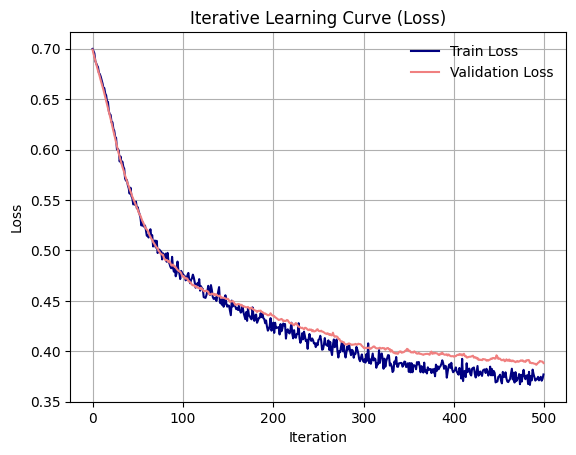

In [76]:
# plot the iterative learning curve (loss)
plt.plot(net.history[:, 'train_loss'], label='Train Loss', color='navy')
plt.plot(net.history[:, 'valid_loss'], label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

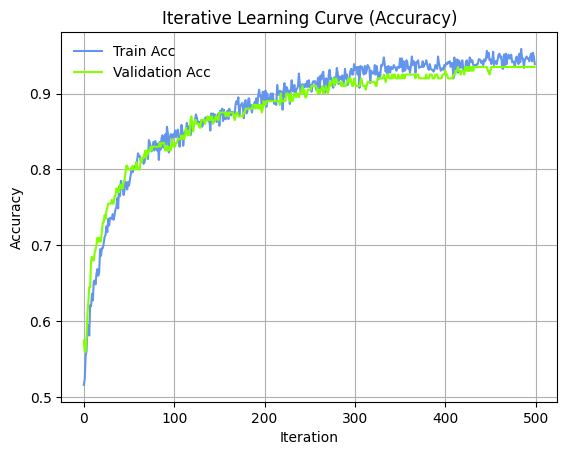

In [77]:
# plot the iterative learning curve (accuracy)
plt.plot(net.history[:, 'train_acc'], label='Train Acc', color='cornflowerblue')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Iterative Learning Curve (Accuracy)")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn learning curve with RO

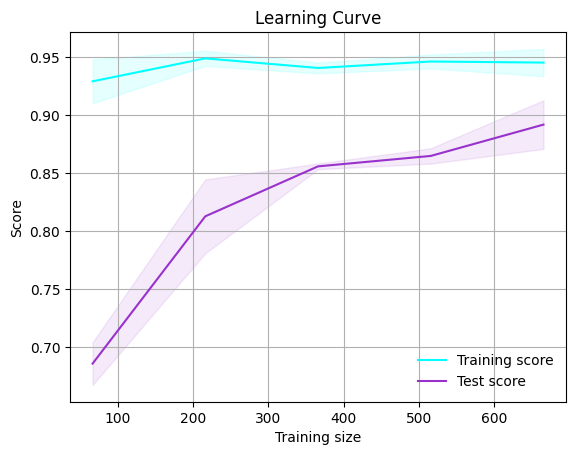

In [78]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## Using sklearn pipeline

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(X, y)
y_proba = pipe.predict_proba(X)

## Using sklearn grid search 

In [81]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

default_params = {
    'module__layer_sizes': [(12, 32, 20, 2)],
}

# module specific parameters need to begin with 'module__'
grid_search_params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__dropout_percent': [.05, .1, .2],
    **default_params,
}

#change n_jobs to run jobs in parallel, see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 
gs = GridSearchCV(net, grid_search_params, n_jobs=1, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END lr=0.01, max_epochs=10, module__dropout_percent=0.05, module__layer_sizes=(12, 32, 20, 2); total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__dropout_percent=0.05, module__layer_sizes=(12, 32, 20, 2); total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__dropout_percent=0.05, module__layer_sizes=(12, 32, 20, 2); total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__dropout_percent=0.1, module__layer_sizes=(12, 32, 20, 2); total time=   0.2s
[CV] END lr=0.01, max_epochs=10, module__dropout_percent=0.1, module__layer_sizes=(12, 32, 20, 2); total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__dropout_percent=0.1, module__layer_sizes=(12, 32, 20, 2); total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__dropout_percent=0.2, module__layer_sizes=(12, 32, 20, 2); total time=   0.1s
[CV] END lr=0.01, max_epochs=10, module__dropout_percent=0.2, module__layer_sizes=(12, 32, 20, 2); total time=